<a href="https://colab.research.google.com/github/a2subedi/streamlit-dssg/blob/main/ModelPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00


In [168]:
# Imports

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import itertools

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import math
import random

import pmdarima as pm

import warnings
# warnings.filterwarnings('ignore')

In [71]:
initial_df = pd.read_csv("/content/drive/MyDrive/dataset.csv", parse_dates=['year'])

In [171]:
# get required indicators
INDICATORS_LIST = [
  "Government expenditure on education, total (% of GDP)",
  "Labor force, total",
  "Literacy rate, adult total (% of people ages 15 and above)",
  "Population ages 15-64 (% of total population)",
  "School enrollment, primary (% gross)",
  "School enrollment, secondary (% gross)",
  "School enrollment, tertiary (% gross)",
  "Unemployment, total (% of total labor force) (modeled ILO estimate)",
  "Central government debt, total (% of GDP)",
  "GDP (current US$)",
  "GDP growth (annual %)",
  "GDP per capita growth (annual %)",
  "GDP per capita, PPP (current international $)",
  "Population, total"
]

ECONOMIC_INDICATORS = [
  "GDP (current US$)",
  "GDP growth (annual %)",
  "GDP per capita growth (annual %)",
  "GDP per capita, PPP (current international $)",
  "Population, total",
  "Central government debt, total (% of GDP)",
  "Unemployment, total (% of total labor force) (modeled ILO estimate)"
  "Population ages 15-64 (% of total population)"
]

EDUCATIONAL_INDICATORS = [
  "School enrollment, primary (% gross)",
  "School enrollment, secondary (% gross)",
  "School enrollment, tertiary (% gross)",
  "Literacy rate, adult total (% of people ages 15 and above)",
  "Government expenditure on education, total (% of GDP)",
]

In [278]:
# Helper Functions

def get_df_from_indicators_and_country(df, indicator1, indicator2, country):
    # extract column ["Country Code", "Country Name", "Indicator Name", "year", "value"]
    df = df[["Country Code", "Country Name", "Indicator Name", "year", "value"]]
    return df

def process_one_indicator(df, indicator):
    # extract rows with indicator
    df = df[(df["Indicator Name"] == indicator) | (df["Indicator Code"] == indicator)]
    # only have year, value
    df = df[["year", "value"]]
    return df

def get_first_df_with_indicators_years_and_values(df, country):
    # extract columns ["Country Code", "Country Name", "Indicator Name", "Indicator Code", "year", "value"]
    df = df[(df["Country Name"] == country) | (df["Country Code"] == country)]
    df = df[["Country Code", "Country Name", "Indicator Name", "Indicator Code", "year", "value"]].dropna()
    # extract rows with country
    return df

def get_indicators(df):
    return df[df['Indicator Name'].isin(INDICATORS_LIST)].drop_duplicates().set_index('Indicator Code')['Indicator Name'].to_dict()

def get_countries(df):
    return df[['Country Name','Country Code']].drop_duplicates().set_index('Country Name')['Country Code'].to_dict()

def get_country_indicators(df, country):
    # Filter for the specified country
    country_df = df[((df["Country Name"] == country) | (df["Country Code"] == country)) & (df['Indicator Name'].isin(INDICATORS_LIST))]

    # Pivot the dataframe
    pivot_df = country_df.pivot(index='year', columns='Indicator Code', values='value')

    # Reset index to make 'year' a column
    # pivot_df.reset_index(inplace=True)

    return pivot_df


def drop_all_indicators_which_dont_have_enough_data(df):
    # drop counts which don't have 53 years
    description = df.describe(include='all')

    # Get the count of non-null values for each column
    non_null_counts = description.loc['count']

    # Filter columns that have exactly 53 non-null values
    columns_to_keep = non_null_counts[non_null_counts >= 52].index.to_list()

    print (columns_to_keep)

    # Drop columns that do not have exactly 53 non-null values
    df_filtered = df[columns_to_keep].dropna()
    return df_filtered
    # print(df_filtered)

def check_df(dataset, head = 5):
    print('#'*30 + ' Shape of Dataset ' + '#'*30, end = '\n'*2)
    print(dataset.shape, end = '\n'*2)
    print('#'*30 + ' General informations about to Dataset ' + '#'*30, end = '\n'*2)
    print(dataset.info(), end = '\n'*2)
    print('#'*30 + ' First 5 Lines Of Dataset ' + '#'*30, end = '\n'*2)
    print(dataset.head(head), end = '\n'*2)
    print('#'*30 + ' NaN values of Features ' + '#'*30, end = '\n'*2)
    print(dataset.isnull().sum(), end = '\n'*2)
    print('#'*30 + ' Descriptive Statistics of Numerical Features ' + '#'*30, end = '\n'*2)
    print(dataset.describe().T, end = '\n'*2)
    print('#'*30 + ' Quantiles of Numerical Features ' + '#'*30, end ='\n'*2)
    print(dataset.describe([0,0.10, 0.25, 0.50,0.75,0.99]).T, end = '\n'*2)

In [320]:
country_code = "SAS"
indicators_dict = get_indicators(initial_df)

In [321]:
first_df = get_country_indicators(initial_df, country_code)
# check_df(first_df)
first_df.sample(5)


Indicator Code,GC.DOD.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD.ZG,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.PP.CD,SE.ADT.LITR.ZS,SE.PRM.ENRR,SE.SEC.ENRR,SE.TER.ENRR,SE.XPD.TOTL.GD.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.ZS,SP.POP.1564.TO.ZS,SP.POP.TOTL
year,,,,,,,,,,,,,,
1970-01-01,NaN,8.569562e+10,5.907193,3.512903,NaN,NaN,71.034363,22.638060,4.150880,NaN,NaN,NaN,54.836457,7.203992e+08
1979-01-01,NaN,1.956560e+11,-2.537547,-4.762279,NaN,37.980049,75.191757,25.616310,4.371350,1.968940,NaN,NaN,55.592650,8.840316e+08
2011-01-01,52.180609,2.293960e+12,5.070749,3.552160,4268.239073,66.505966,101.118057,58.984211,19.165600,2.841880,614395834.0,7.019120,63.045730,1.684898e+09
2014-01-01,50.613102,2.614764e+12,6.847966,5.486720,4976.510795,68.793167,103.284508,65.622787,21.236481,2.975962,641315490.0,6.988910,64.063557,1.754030e+09
1994-01-01,51.374497,4.321143e+11,5.915458,3.622549,1525.631056,48.849380,88.566406,42.090542,5.074000,NaN,413629078.0,6.031836,57.661188,1.246157e+09


In [322]:
resampled_first_df = first_df.resample('YS').mean().fillna(method="backfill").fillna(method="ffill")
resampled_first_df.sample(5)
# second_df = first_df

Indicator Code,GC.DOD.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD.ZG,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.PP.CD,SE.ADT.LITR.ZS,SE.PRM.ENRR,SE.SEC.ENRR,SE.TER.ENRR,SE.XPD.TOTL.GD.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.ZS,SP.POP.1564.TO.ZS,SP.POP.TOTL
year,,,,,,,,,,,,,,
1973-01-01,55.108826,1.047616e+11,3.884563,1.498732,1262.994205,36.039341,76.396049,23.364590,4.301180,1.83042,384244852.0,6.050183,54.993632,7.700837e+08
2016-01-01,47.680245,3.010885e+12,7.776017,6.484948,5519.560321,71.104927,109.457001,67.380249,22.428499,3.22929,660953673.0,6.922156,64.679469,1.797073e+09
1986-01-01,55.108826,3.139755e+11,4.828397,2.411677,1262.994205,42.440369,82.659203,33.300549,5.480610,2.67813,384244852.0,6.050183,56.352386,1.042169e+09
2003-01-01,60.998300,8.116194e+11,7.176112,5.212437,2435.808280,60.095779,95.908607,45.517632,8.997130,3.11435,530806921.0,7.277299,60.296131,1.489358e+09
1975-01-01,55.108826,1.358418e+11,6.893929,4.458169,1262.994205,36.039341,76.936150,23.809340,4.308880,1.98008,384244852.0,6.050183,55.130580,8.065928e+08


In [323]:
second_df = drop_all_indicators_which_dont_have_enough_data(resampled_first_df)
second_df

['GC.DOD.TOTL.GD.ZS', 'NY.GDP.MKTP.CD', 'NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.KD.ZG', 'NY.GDP.PCAP.PP.CD', 'SE.ADT.LITR.ZS', 'SE.PRM.ENRR', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'SE.XPD.TOTL.GD.ZS', 'SL.TLF.TOTL.IN', 'SL.UEM.TOTL.ZS', 'SP.POP.1564.TO.ZS', 'SP.POP.TOTL']


Indicator Code,GC.DOD.TOTL.GD.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD.ZG,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.PP.CD,SE.ADT.LITR.ZS,SE.PRM.ENRR,SE.SEC.ENRR,SE.TER.ENRR,SE.XPD.TOTL.GD.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.ZS,SP.POP.1564.TO.ZS,SP.POP.TOTL
year,,,,,,,,,,,,,,
1970-01-01,55.108826,8.569562e+10,5.907193,3.512903,1262.994205,36.039341,71.034363,22.638060,4.150880,1.830420,384244852.0,6.050183,54.836457,7.203992e+08
1971-01-01,55.108826,9.115198e+10,0.615789,-1.535059,1262.994205,36.039341,70.713013,22.678320,4.173610,1.830420,384244852.0,6.050183,54.889624,7.361354e+08
1972-01-01,55.108826,9.163598e+10,-1.761851,-3.885173,1262.994205,36.039341,72.512497,23.006350,4.238170,1.830420,384244852.0,6.050183,54.937638,7.523978e+08
1973-01-01,55.108826,1.047616e+11,3.884563,1.498732,1262.994205,36.039341,76.396049,23.364590,4.301180,1.830420,384244852.0,6.050183,54.993632,7.700837e+08
1974-01-01,55.108826,1.269106e+11,2.475953,0.118929,1262.994205,36.039341,75.939713,23.555710,4.325590,1.980080,384244852.0,6.050183,55.051656,7.882132e+08
1975-01-01,55.108826,1.358418e+11,6.893929,4.458169,1262.994205,36.039341,76.936150,23.809340,4.308880,1.980080,384244852.0,6.050183,55.130580,8.065928e+08
1976-01-01,55.108826,1.325833e+11,2.605459,0.299099,1262.994205,36.044250,76.891998,23.853230,4.297260,1.968940,384244852.0,6.050183,55.225475,8.251402e+08
1977-01-01,55.108826,1.535245e+11,6.221170,3.823042,1262.994205,36.695702,78.544930,24.409630,4.197820,1.968940,384244852.0,6.050183,55.334641,8.441995e+08
1978-01-01,55.108826,1.746887e+11,6.137368,3.722735,1262.994205,37.343922,75.359978,24.792280,4.278880,1.968940,384244852.0,6.050183,55.463155,8.638522e+08


In [324]:
indicators_dict

{'SE.XPD.TOTL.GD.ZS': 'Government expenditure on education, total (% of GDP)',
 'SL.TLF.TOTL.IN': 'Labor force, total',
 'SE.ADT.LITR.ZS': 'Literacy rate, adult total (% of people ages 15 and above)',
 'SP.POP.1564.TO.ZS': 'Population ages 15-64 (% of total population)',
 'SE.PRM.ENRR': 'School enrollment, primary (% gross)',
 'SE.SEC.ENRR': 'School enrollment, secondary (% gross)',
 'SE.TER.ENRR': 'School enrollment, tertiary (% gross)',
 'SL.UEM.TOTL.ZS': 'Unemployment, total (% of total labor force) (modeled ILO estimate)',
 'GC.DOD.TOTL.GD.ZS': 'Central government debt, total (% of GDP)',
 'NY.GDP.MKTP.CD': 'GDP (current US$)',
 'NY.GDP.MKTP.KD.ZG': 'GDP growth (annual %)',
 'NY.GDP.PCAP.KD.ZG': 'GDP per capita growth (annual %)',
 'NY.GDP.PCAP.PP.CD': 'GDP per capita, PPP (current international $)',
 'SP.POP.TOTL': 'Population, total'}

In [325]:
second_df.columns

Index(['GC.DOD.TOTL.GD.ZS', 'NY.GDP.MKTP.CD', 'NY.GDP.MKTP.KD.ZG',
       'NY.GDP.PCAP.KD.ZG', 'NY.GDP.PCAP.PP.CD', 'SE.ADT.LITR.ZS',
       'SE.PRM.ENRR', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'SE.XPD.TOTL.GD.ZS',
       'SL.TLF.TOTL.IN', 'SL.UEM.TOTL.ZS', 'SP.POP.1564.TO.ZS', 'SP.POP.TOTL'],
      dtype='object', name='Indicator Code')

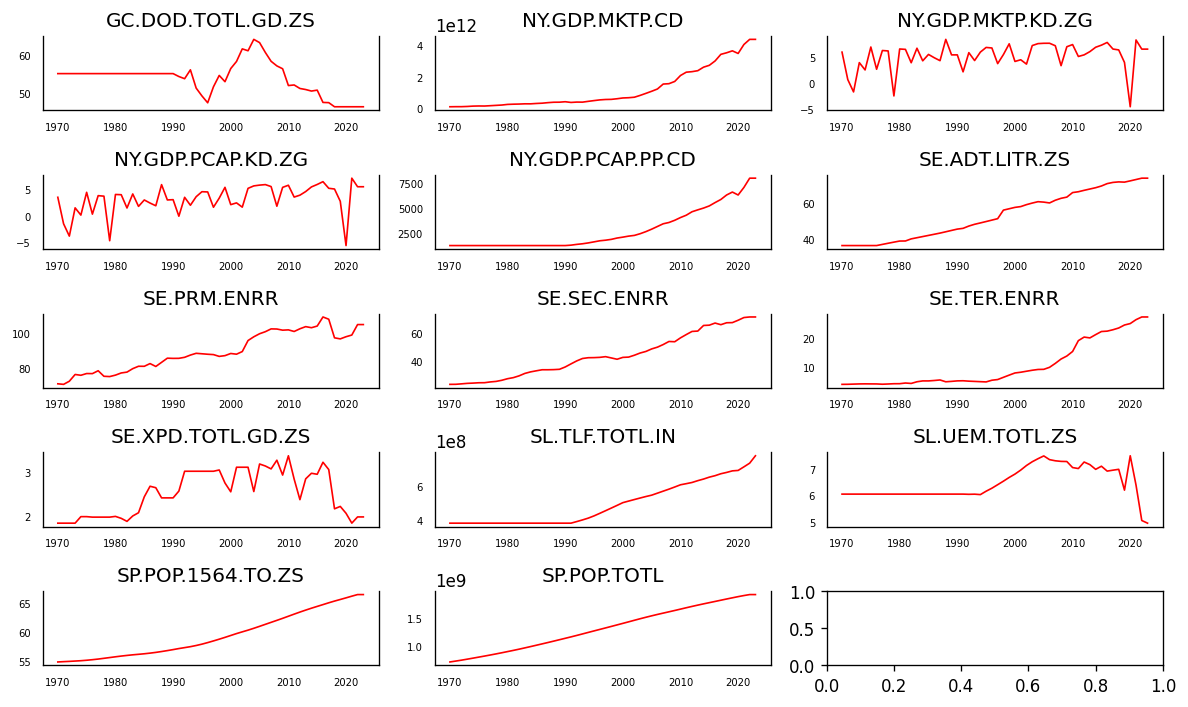

In [326]:
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    try:
      data = second_df[second_df.columns[i]]
      ax.plot(data, color='red', linewidth=1)
      # Decorations
      ax.set_title(second_df.columns[i])
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    except:
      break

plt.tight_layout()


In [327]:
for each in second_df.columns:
  if each != 'year':
    ad_fuller_result_1 = adfuller(second_df[each].diff()[1:])

    print(f'{each}, {indicators_dict.get(each)}')
    print(f'ADF Statistic: {ad_fuller_result_1[0]}')
    print(f'p-value: {ad_fuller_result_1[1]} \n')

GC.DOD.TOTL.GD.ZS, Central government debt, total (% of GDP)
ADF Statistic: -6.365225856584316
p-value: 2.4191489890387315e-08 

NY.GDP.MKTP.CD, GDP (current US$)
ADF Statistic: 0.056983356649252775
p-value: 0.9629984231117721 

NY.GDP.MKTP.KD.ZG, GDP growth (annual %)
ADF Statistic: -5.3261739673674136
p-value: 4.831907667726661e-06 

NY.GDP.PCAP.KD.ZG, GDP per capita growth (annual %)
ADF Statistic: -5.412335284520448
p-value: 3.190887655492825e-06 

NY.GDP.PCAP.PP.CD, GDP per capita, PPP (current international $)
ADF Statistic: 1.45563583933307
p-value: 0.9973527947262896 

SE.ADT.LITR.ZS, Literacy rate, adult total (% of people ages 15 and above)
ADF Statistic: -6.328256270515583
p-value: 2.94958373049955e-08 

SE.PRM.ENRR, School enrollment, primary (% gross)
ADF Statistic: -4.412432817553422
p-value: 0.00028214976048092545 

SE.SEC.ENRR, School enrollment, secondary (% gross)
ADF Statistic: -3.241044412317326
p-value: 0.01772844831742503 

SE.TER.ENRR, School enrollment, tertiary

In [291]:
print ("does SE.TER.ENRR causes NY.GDP.MKTP.CD")
granger_2 = grangercausalitytests(second_df[['NY.GDP.MKTP.CD', 'SE.TER.ENRR']], 9)

# for pair in itertools.combinations(second_df.columns, 2):
#     print(f"Granger causality test for columns: {pair}")
#     granger_result = grangercausalitytests(second_df[list(pair)], 4)
#     # print(granger_result)
#     print('\n')

does SE.TER.ENRR causes NY.GDP.MKTP.CD

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=246.1449, p=0.0000  , df_denom=50, df_num=1
ssr based chi2 test:   chi2=260.9135, p=0.0000  , df=1
likelihood ratio test: chi2=94.2778 , p=0.0000  , df=1
parameter F test:         F=246.1449, p=0.0000  , df_denom=50, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=133.4342, p=0.0000  , df_denom=47, df_num=2
ssr based chi2 test:   chi2=295.2587, p=0.0000  , df=2
likelihood ratio test: chi2=98.7390 , p=0.0000  , df=2
parameter F test:         F=133.4342, p=0.0000  , df_denom=47, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=66.2431 , p=0.0000  , df_denom=44, df_num=3
ssr based chi2 test:   chi2=230.3452, p=0.0000  , df=3
likelihood ratio test: chi2=87.0956 , p=0.0000  , df=3
parameter F test:         F=66.2431 , p=0.0000  , df_denom=44, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F tes

In [292]:
granger_1 = grangercausalitytests(second_df[['SE.TER.ENRR', 'NY.GDP.MKTP.CD']], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3245  , p=0.0742  , df_denom=50, df_num=1
ssr based chi2 test:   chi2=3.5240  , p=0.0605  , df=1
likelihood ratio test: chi2=3.4118  , p=0.0647  , df=1
parameter F test:         F=3.3245  , p=0.0742  , df_denom=50, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2044  , p=0.0009  , df_denom=47, df_num=2
ssr based chi2 test:   chi2=18.1543 , p=0.0001  , df=2
likelihood ratio test: chi2=15.5716 , p=0.0004  , df=2
parameter F test:         F=8.2044  , p=0.0009  , df_denom=47, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5982  , p=0.0003  , df_denom=44, df_num=3
ssr based chi2 test:   chi2=26.4209 , p=0.0000  , df=3
likelihood ratio test: chi2=21.2890 , p=0.0001  , df=3
parameter F test:         F=7.5982  , p=0.0003  , df_denom=44, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3078  , p=0.0015  , df_d

In [364]:
third_df_for_training = second_df[['SE.TER.ENRR', 'NY.GDP.MKTP.CD']]
print(third_df_for_training.shape)

(54, 2)


In [365]:
train_df=third_df_for_training[:-4]
test_df=third_df_for_training[-4:]

print(test_df.shape)


(4, 2)


In [383]:

model = VAR(train_df.diff()[1:])

sorted_order=model.select_order(maxlags=4)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       49.83       49.91   4.368e+21       49.86
1       49.23       49.47   2.403e+21       49.32
2       49.22       49.62   2.389e+21       49.37
3       49.11       49.67   2.131e+21       49.32
4      48.73*      49.46*  1.477e+21*      49.00*
-------------------------------------------------


In [384]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



LinAlgError: Schur decomposition solver error.

In [368]:
n_forecast = 20
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean


predictions.columns=['SE.TER.ENRR_predicted','NY.GDP.MKTP.CD_predicted']
predictions



,SE.TER.ENRR_predicted,NY.GDP.MKTP.CD_predicted
2020-01-01,2.758866e+09,8.261369e+13
2021-01-01,4.135057e+09,1.211547e+14
2022-01-01,3.545664e+08,8.948294e+12
2023-01-01,-1.834180e+09,-5.416800e+13
2024-01-01,-8.874058e+08,-2.863472e+13
2025-01-01,-5.077286e+09,-1.512163e+14
2026-01-01,-4.532090e+09,-1.342678e+14
2027-01-01,-3.679440e+09,-1.109252e+14
2028-01-01,-6.292836e+09,-1.856304e+14
2029-01-01,-2.864030e+09,-8.454952e+13


In [369]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)
test_vs_pred

,SE.TER.ENRR,NY.GDP.MKTP.CD,SE.TER.ENRR_predicted,NY.GDP.MKTP.CD_predicted
2020-01-01,25.029079,3.489924e+12,2.758866e+09,8.261369e+13
2021-01-01,26.367300,4.062850e+12,4.135057e+09,1.211547e+14
2022-01-01,27.294201,4.390348e+12,3.545664e+08,8.948294e+12
2023-01-01,27.294201,4.390348e+12,-1.834180e+09,-5.416800e+13
2024-01-01,NaN,NaN,-8.874058e+08,-2.863472e+13
2025-01-01,NaN,NaN,-5.077286e+09,-1.512163e+14
2026-01-01,NaN,NaN,-4.532090e+09,-1.342678e+14
2027-01-01,NaN,NaN,-3.679440e+09,-1.109252e+14
2028-01-01,NaN,NaN,-6.292836e+09,-1.856304e+14
2029-01-01,NaN,NaN,-2.864030e+09,-8.454952e+13


In [370]:
import plotly.express as px

# test_vs_pred.plot(figsize=(12,5))

px.line(test_vs_pred, x=test_vs_pred.index, y=['SE.TER.ENRR', 'SE.TER.ENRR_predicted'])



In [371]:
px.line(test_vs_pred, x=test_vs_pred.index, y=['NY.GDP.MKTP.CD', 'NY.GDP.MKTP.CD_predicted'])

# AUTO ARIMA


In [372]:
third_df_for_training.sample(2)

Indicator Code,SE.TER.ENRR,NY.GDP.MKTP.CD
year,,
2021-01-01,26.367300,4.062850e+12
2023-01-01,27.294201,4.390348e+12


In [373]:
model = pm.auto_arima(third_df_for_training['NY.GDP.MKTP.CD'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=9, error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)
model2 = pm.auto_arima(third_df_for_training['SE.TER.ENRR'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=9, error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=2853.395, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2830.017, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2824.935, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2802.787, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2802.257, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2802.922, Time=0.08 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2804.778, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=2803.552, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=2802.481, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2823.712, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=2805.060, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2806.338, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.827 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]        

In [374]:
model.fit(train_df['NY.GDP.MKTP.CD'])
model2.fit(train_df['SE.TER.ENRR'])

ARIMA(order=(2, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [375]:
forecast=model.predict(n_periods=20, return_conf_int=True)
forecast1 = model2.predict(n_periods=20, return_conf_int=True)

In [376]:
forecast

(2020-01-01    3.842777e+12
 2021-01-01    4.027338e+12
 2022-01-01    4.211899e+12
 2023-01-01    4.396459e+12
 2024-01-01    4.581020e+12
 2025-01-01    4.765581e+12
 2026-01-01    4.950142e+12
 2027-01-01    5.134702e+12
 2028-01-01    5.319263e+12
 2029-01-01    5.503824e+12
 2030-01-01    5.688384e+12
 2031-01-01    5.872945e+12
 2032-01-01    6.057506e+12
 2033-01-01    6.242067e+12
 2034-01-01    6.426627e+12
 2035-01-01    6.611188e+12
 2036-01-01    6.795749e+12
 2037-01-01    6.980309e+12
 2038-01-01    7.164870e+12
 2039-01-01    7.349431e+12
 Freq: AS-JAN, dtype: float64,
 array([[3.65900840e+12, 4.02654605e+12],
        [3.73513366e+12, 4.31954222e+12],
        [3.81364401e+12, 4.61015330e+12],
        [3.88929971e+12, 4.90361903e+12],
        [3.96056422e+12, 5.20147595e+12],
        [4.02690622e+12, 5.50425538e+12],
        [4.08816440e+12, 5.81211863e+12],
        [4.14433442e+12, 6.12507005e+12],
        [4.19548300e+12, 6.44304290e+12],
        [4.24170912e+12, 6.7659

In [377]:
forecast1

(2020-01-01    25.354116
 2021-01-01    26.006452
 2022-01-01    26.826671
 2023-01-01    27.684996
 2024-01-01    28.438223
 2025-01-01    29.204684
 2026-01-01    30.024845
 2027-01-01    30.820191
 2028-01-01    31.593986
 2029-01-01    32.388506
 2030-01-01    33.188164
 2031-01-01    33.974707
 2032-01-01    34.762689
 2033-01-01    35.557442
 2034-01-01    36.349193
 2035-01-01    37.138185
 2036-01-01    37.929734
 2037-01-01    38.721972
 2038-01-01    39.512574
 2039-01-01    40.303329
 Freq: AS-JAN, dtype: float64,
 array([[24.31132671, 26.39690485],
        [23.97313488, 28.03976917],
        [23.98608913, 29.66725291],
        [23.86051497, 31.50947756],
        [23.39726276, 33.47918344],
        [22.90851448, 35.50085386],
        [22.42477334, 37.62491761],
        [21.79261049, 39.84777222],
        [21.05052866, 42.13744263],
        [20.27587887, 44.50113238],
        [19.43229965, 46.944029  ],
        [18.49633948, 49.45307379],
        [17.49997456, 52.02540376],
 

In [378]:
forecast_range=pd.date_range(start='2011-01-01', periods=20,freq='YS')
forecast_range

DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01',
               '2023-01-01', '2024-01-01', '2025-01-01', '2026-01-01',
               '2027-01-01', '2028-01-01', '2029-01-01', '2030-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [379]:
forecast_df = pd.DataFrame(forecast[0],index =forecast_range,columns=['Prediction'])
forecast_df.sample(5)

,Prediction
2021-01-01,4.027338e+12
2015-01-01,NaN
2027-01-01,5.134702e+12
2026-01-01,4.950142e+12
2012-01-01,NaN


In [380]:
forecast1_df = pd.DataFrame(forecast1[0],index =forecast_range,columns=['Prediction'])
forecast1_df.sample(5)

,Prediction
2011-01-01,NaN
2018-01-01,NaN
2024-01-01,28.438223
2025-01-01,29.204684
2028-01-01,31.593986


<Axes: >

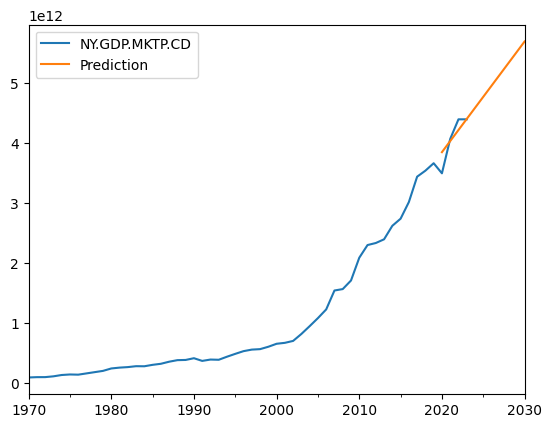

In [381]:
final_df = third_df_for_training
pd.concat([final_df['NY.GDP.MKTP.CD'],forecast_df],axis=1).plot()

Indicator Code,SE.TER.ENRR,NY.GDP.MKTP.CD
year,,
1978-01-01,4.27888,1.746887e+11
1990-01-01,5.34778,4.069897e+11
1982-01-01,4.47030,2.587440e+11
1975-01-01,4.30888,1.358418e+11
1986-01-01,5.48061,3.139755e+11


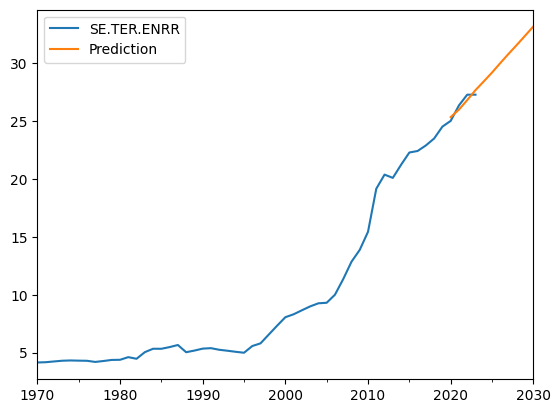

In [382]:
final_df_1 = third_df_for_training
pd.concat([final_df_1['SE.TER.ENRR'],forecast1_df],axis=1).plot()
final_df_1.sample(5)